# T5 NusaX-MT Sundanese-English Machine Translation


Translation converts a sequence of text from one language to another. It is one of several tasks you can formulate as a sequence-to-sequence problem, a powerful framework for returning some output from an input, like translation or summarization. Translation systems are commonly used for translation between different language texts, but it can also be used for speech or some combination in between like text-to-speech or speech-to-text.


Before you begin, make sure you have all the necessary libraries installed:

# Install & Import Dependencies

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

In [ ]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

from datasets import Dataset as DatasetHF
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


# Load Datasets

Start by loading the Full NusaX datasets and Sundanese to English NusaX SubDataset

In [ ]:
nusax_mt = load_dataset("indonlp/NusaX-MT")
nusax_sun_eng = load_dataset("indonlp/NusaX-MT", name='sun-eng')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

# Exploratory Datasets Analysis

Before using the datasets we should do some Exploratory to gain more information about the datasets

In [ ]:
display(nusax_mt)
display(nusax_sun_eng)

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

### Convert Datasets HuggingFace into Pandas Dataframe

Before explore it we need to convert the datasets into pandas/dataframe type cause the datasets was in huggingface format

In [ ]:
nusax_mt_df_train = nusax_mt['train'].to_pandas()
nusax_mt_df_test = nusax_mt['test'].to_pandas()
nusax_mt_df_valid = nusax_mt['validation'].to_pandas()

nusax_sun_eng_df_train = nusax_sun_eng['train'].to_pandas()
nusax_sun_eng_df_test = nusax_sun_eng['test'].to_pandas()
nusax_sun_eng_df_valid = nusax_sun_eng['validation'].to_pandas()

In [ ]:
display(nusax_mt_df_train)
print('#'*100)
display(nusax_sun_eng_df_train)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
65995,65995,Si A pangkataionna tong kosong nyaring bunyina...,Si A nyarita tong kosong heuras bunyina bicara...,bbc,sun
65996,65996,Sambalna dang nahaluluan di inganan na asing. ...,Sambelna moal aya di tempat nu sanes. Rasa tar...,bbc,sun
65997,65997,"Pandapothu lumayan do hu lala steak nai, alai ...","Numutkeun abdi steakna cekap raos, mung leuwih...",bbc,sun
65998,65998,radotu sipanganon on dah gus na lagi musim na ...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,bbc,sun


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Enjoy 0% instalment for up to 12 months when o...,sun,eng
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,The cakes give me massive nostalgia. Everythin...,sun,eng
2,2,Ibu kantos ngadamel di grab indonesia,Mom once worked for grab indonesia.,sun,eng
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,"I love having lunch here the most, thanks to t...",sun,eng
4,4,Palayanan beus DAMRI sae pisan,The DAMRI Bus service is really good,sun,eng
...,...,...,...,...,...
495,495,Si A nyarita tong kosong heuras bunyina bicara...,A talks like empty vessels that make the most ...,sun,eng
496,496,Sambelna moal aya di tempat nu sanes. Rasa tar...,You won't find this sambal anywhere else. The ...,sun,eng
497,497,"Numutkeun abdi steakna cekap raos, mung leuwih...","I think the steak was quite good, my advice is...",sun,eng
498,498,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,"Watch what you eat, Gus, it's that kind of sea...",sun,eng


### Merge Splited Datasets

after convert the datasets into dataframe we need to merge/concat the splitted dataframe, so we can analys the data easly

In [ ]:
sun_eng_df = pd.concat(
    [
        nusax_sun_eng_df_train,
        nusax_sun_eng_df_test,
        nusax_sun_eng_df_valid
    ],
    axis=0,
    ignore_index=True
    )

nusax_full_df = pd.concat(
    [
        nusax_mt_df_train,
        nusax_mt_df_test,
        nusax_mt_df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(sun_eng_df)
print('#'*100)
display(nusax_full_df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Enjoy 0% instalment for up to 12 months when o...,sun,eng
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,The cakes give me massive nostalgia. Everythin...,sun,eng
2,2,Ibu kantos ngadamel di grab indonesia,Mom once worked for grab indonesia.,sun,eng
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,"I love having lunch here the most, thanks to t...",sun,eng
4,4,Palayanan beus DAMRI sae pisan,The DAMRI Bus service is really good,sun,eng
...,...,...,...,...,...
995,95,Mohon informasikeun atm mana wae di semarang n...,Please inform which ATM in Semarang can be use...,sun,eng
996,96,Rerencangan nyarankeun tempat ieu kusabab rasa...,My friend recommended this place because of it...,sun,eng
997,97,"Mimiti kuring kadieu nganggap enteng, sawaktos...","The first time coming here, I understimated th...",sun,eng
998,98,Tempatna nyenengkeun nya kanggo nu atos berkul...,The venue's fun both for people with families ...,sun,eng


####################################################################################################


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
131995,13195,Tolong jolo paboa atm na didia do di semarang ...,Mohon informasikeun atm mana wae di semarang n...,bbc,sun
131996,13196,Dongan mangarekomendasihon inganan on alani da...,Rerencangan nyarankeun tempat ieu kusabab rasa...,bbc,sun
131997,13197,Parjolo sahali au ro tuson dang apala lomo roh...,"Mimiti kuring kadieu nganggap enteng, sawaktos...",bbc,sun
131998,13198,"Inganan na tabo, denggan laho tu akka naung ma...",Tempatna nyenengkeun nya kanggo nu atos berkul...,bbc,sun


### Setences Length

First the easiest way is to check the sentence length from the each languages in the datasets. We can use apply and lambda function to get the length

In [ ]:
nusax_full_df['text_1_length'] = nusax_full_df['text_1'].apply(lambda x: len(x.split()))
nusax_full_df['text_2_length'] = nusax_full_df['text_2'].apply(lambda x: len(x.split()))
sun_eng_df['text_1_length'] = sun_eng_df['text_1'].apply(lambda x: len(x.split()))
sun_eng_df['text_2_length'] = sun_eng_df['text_2'].apply(lambda x: len(x.split()))

display(nusax_full_df.describe())
display(sun_eng_df.describe())

,text_1_length,text_2_length
count,132000.000000,132000.000000
mean,24.171417,24.171417
std,15.180737,15.180737
min,1.000000,1.000000
25%,13.000000,13.000000
50%,20.000000,20.000000
75%,32.000000,32.000000
max,107.000000,107.000000


,text_1_length,text_2_length
count,1000.000000,1000.000000
mean,23.098000,28.578000
std,14.290298,17.975735
min,1.000000,2.000000
25%,12.000000,15.000000
50%,19.000000,24.000000
75%,31.000000,37.250000
max,76.000000,107.000000


### Check Languages Distribution

After that we also need to check the languages distribution, we can use library Matplotlib and Seaborn to do that.

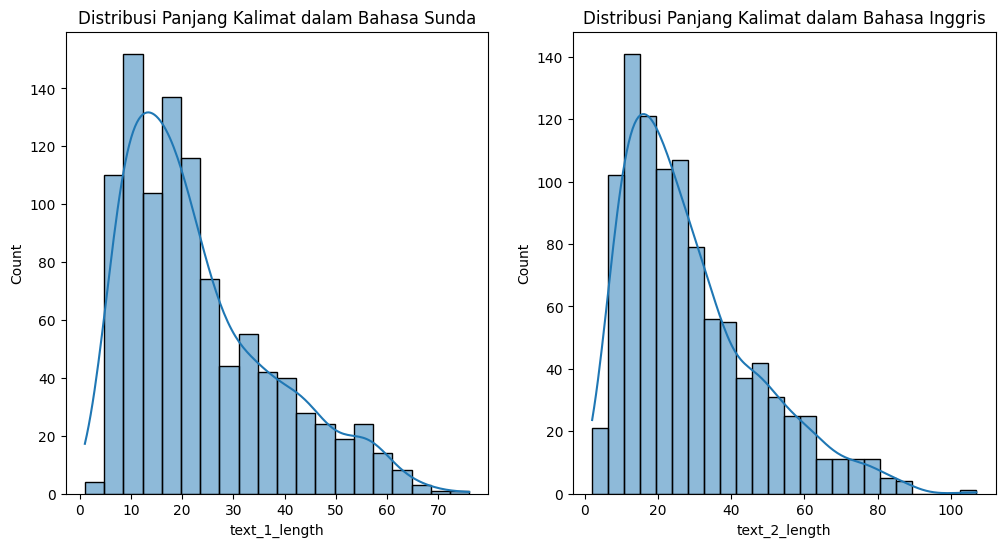

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(sun_eng_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.histplot(sun_eng_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Inggris')

plt.show()


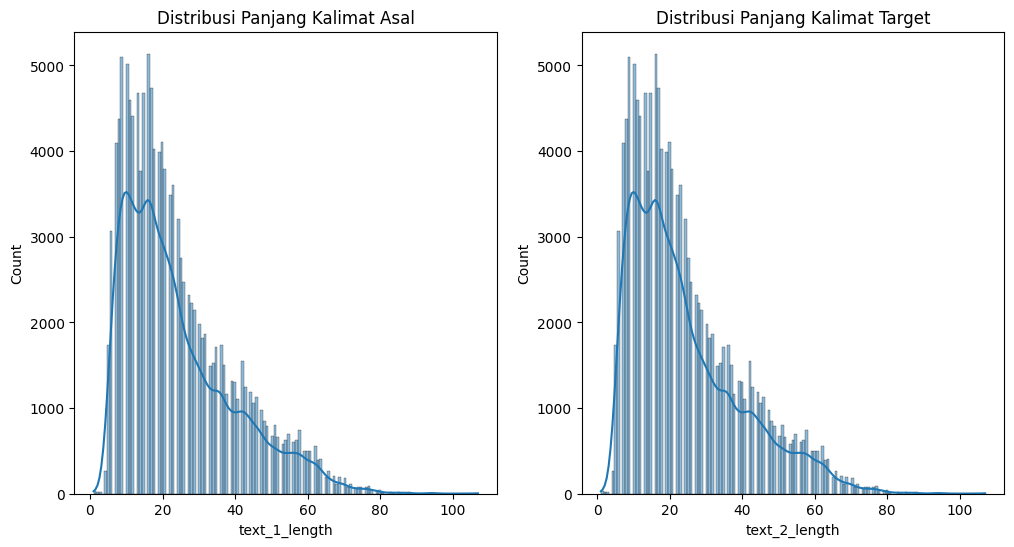

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(nusax_full_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Asal')

plt.subplot(1,2,2)
sns.histplot(nusax_full_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat Target')

plt.show()


### Most Common Words

After that let see the most common words in each languaes using Counter From Collections Library. And After that we can also visualize it using Matplotlib and Seaborn

In [ ]:
# kata kata paling umum
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

print("Kata-kata Paling Umum dalam Bahasa Sunda:")
print(get_most_common_words(sun_eng_df['text_1']))

print("\nKata-kata Paling Umum dalam Bahasa Inggris:")
print(get_most_common_words(sun_eng_df['text_2']))

Kata-kata Paling Umum dalam Bahasa Sunda:
[('nu', 615), ('sareng', 542), ('di', 457), ('teu', 375), ('abdi', 314), ('ka', 247), ('aya', 216), ('anu', 214), ('kanggo', 198), ('ku', 192)]

Kata-kata Paling Umum dalam Bahasa Inggris:
[('the', 1939), ('and', 709), ('to', 613), ('is', 592), ('a', 574), ('of', 468), ('i', 380), ('for', 379), ('in', 370), ('was', 345)]


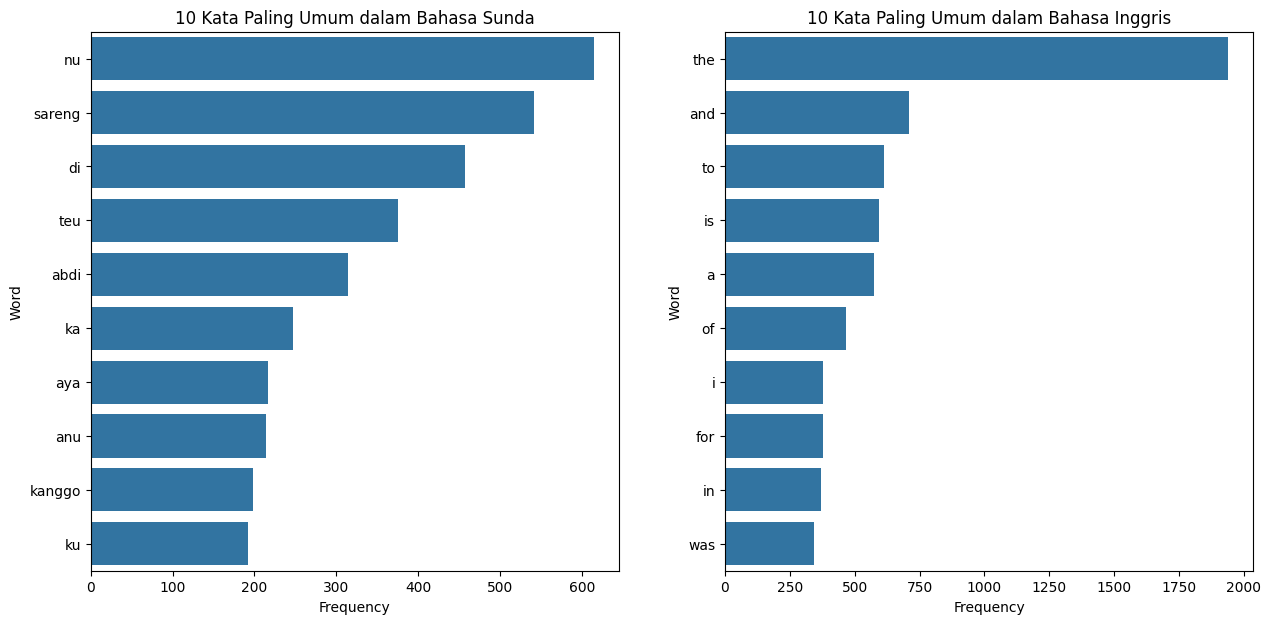

In [ ]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(sun_eng_df['text_1'], 10)
top_eng_words = get_most_common_words(sun_eng_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Inggris')

plt.show()

### N-Grams Analysis

We also can check the most common words using N-Grams function in this below code cell

In [ ]:
def generate_ngrams(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Contoh untuk bigram dalam Bahasa Sunda
sun_bigrams = generate_ngrams(" ".join(sun_eng_df['text_1']), n=2)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Inggris
eng_bigrams = generate_ngrams(" ".join(sun_eng_df['text_2']), n=2)
display(Counter(eng_bigrams).most_common(10))

[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

####################


[('and the', 106),
 ('of the', 94),
 ('in the', 82),
 ('place is', 64),
 ('to the', 60),
 ('the food', 59),
 ('for the', 57),
 ('The food', 52),
 ('for a', 51),
 ('a lot', 51)]

In [ ]:
# Contoh untuk bigram dalam Bahasa Sunda
sun_bigrams = generate_ngrams(" ".join(sun_eng_df['text_1']), n=3)
display(Counter(sun_bigrams).most_common(10))

print('#'*20)

# Contoh untuk bigram dalam Bahasa Inggris
eng_bigrams = generate_ngrams(" ".join(sun_eng_df['text_2']), n=3)
display(Counter(eng_bigrams).most_common(10))

[('nu aya di', 9),
 ('tuang di dieu.', 7),
 ('kanggo tuang wengi', 6),
 ('ka restoran ieu', 5),
 ('tuang di dieu', 5),
 ('tuang wengi sareng', 5),
 ('sumping ka dieu', 5),
 ('salah sahiji tempat', 5),
 ('tuang di tempat', 5),
 ('tuangeun sareng inuman', 5)]

####################


[('a lot of', 40),
 ('The place is', 31),
 ('The food is', 21),
 ('the place is', 16),
 ('The price is', 16),
 ('one of the', 14),
 ('the price is', 13),
 ('the food is', 12),
 ('the food was', 11),
 ('if you wanna', 11)]

### WordClouds

We can also visualize the most common words in the datasets from each languages using WordClouds library.

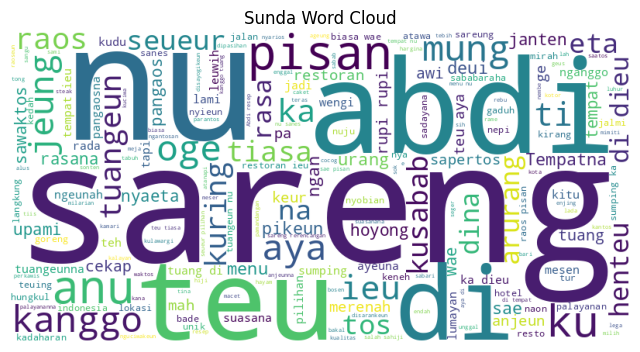

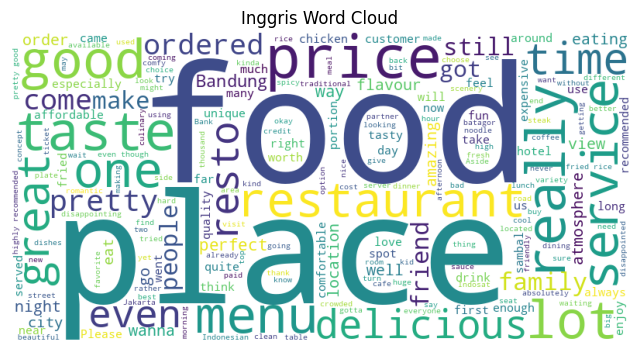

In [ ]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(sun_eng_df['text_1'], 'Sunda Word Cloud')
plot_word_cloud(sun_eng_df['text_2'], 'Inggris Word Cloud')


# Texts Preprocessing

# Datasets Preprocessing

In [ ]:
# data_sun_eng_df = pd.concat(
#     [
#         nusax_sun_eng_df_train,
#         nusax_sun_eng_df_test,
#         ],
#     axis=0,
#     ignore_index=True
#     )

# display(data_sun_eng_df)

In [ ]:
nusax_SunEng = DatasetHF.from_pandas(sun_eng_df)

display(nusax_SunEng)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 1000
})

In [ ]:
# Split the dataset into training, validation, and test sets
split_ratios = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
split_names = ['train', 'validation', 'test']

splits = nusax_SunEng.train_test_split(test_size=split_ratios[1])
train_dataset, valid_test_dataset = splits['train'], splits['test']

splits = valid_test_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = splits['train'], splits['test']

display(train_dataset)
display(test_dataset)
display(valid_dataset)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 900
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 50
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length'],
    num_rows: 50
})

In [ ]:
checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

source_lang = 'sun'
target_lang = 'eng'
prefix = "translate Sundanese to English: "

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The preprocessing function you want to create needs to:

1. Prefix the input with a prompt so T5 knows this is a translation task. Some models capable of multiple NLP tasks require prompting for specific tasks.
2. Tokenize the input (Sundanese) and target (English) separately because you can't tokenize French text with a tokenizer pretrained on an English vocabulary.
3. Truncate sequences to be no longer than the maximum length set by the `max_length` parameter.

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map) method. You can speed up the `map` function by setting `batched=True` to process multiple elements of the dataset at once:

In [ ]:
# def preprocess_function(examples):
#     inputs = [prefix + src for src in examples["text_1"]]
#     targets = examples["text_2"]
#     model_inputs = tokenizer(inputs, targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")
#     return model_inputs

def preprocess_function(examples):
    inputs = [prefix + src for src in examples["text_1"]]
    targets = examples["text_2"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    # Prepare decoder_input_ids
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_nusax_train = train_dataset.map(preprocess_function, batched=True)
tokenized_nusax_test = test_dataset.map(preprocess_function, batched=True)
tokenized_nusax_valid = valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
display(tokenized_nusax_train)
display(tokenized_nusax_test)
display(tokenized_nusax_valid)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 900
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 50
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'text_1_length', 'text_2_length', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 50
})

In [ ]:
tokenized_nusax_train['input_ids'][:1]

[[13959,
  3068,
  3768,
  15,
  7,
  15,
  12,
  1566,
  10,
  4708,
  5808,
  71,
  23001,
  1076,
  23,
  3,
  52,
  9,
  32,
  7,
  1227,
  17,
  76,
  1468,
  62,
  425,
  23,
  5,
  71,
  63,
  9,
  142,
  76,
  1238,
  2285,
  206,
  3,
  7,
  9,
  1496,
  46,
  76,
  3,
  17,
  23,
  9,
  7,
  9,
  1227,
  4953,
  17245,
  5394,
  9,
  77,
  8524,
  5808,
  5,
  17355,
  9,
  107,
  954,
  3304,
  3,
  23,
  15,
  76,
  3,
  2375,
  15,
  206,
  3,
  29,
  2565,
  7066,
  2565,
  3,
  7,
  355,
  1725,
  197,
  18852,
  4553,
  9,
  5,
  4708,
  7223,
  9,
  3,
  32,
  397,
  3,
  52,
  9,
  32,
  7,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [ ]:
tokenized_nusax_train['attention_mask'][:1]

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="T5_NusaX_Sun_Eng",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=30,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_nusax_train,
    eval_dataset=tokenized_nusax_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,0.792775,0.000000,0.000000
2,No log,0.764464,0.000000,0.000000
3,No log,0.716371,0.000000,0.000000
4,No log,0.690954,0.000000,0.000000
5,No log,0.673288,0.000000,0.000000
6,No log,0.652944,0.000000,0.000000
7,No log,0.640201,0.000000,0.000000
8,No log,0.631532,0.000000,0.000000
9,1.292100,0.621972,0.000000,0.000000
10,1.292100,0.614305,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=1710, training_loss=0.8020450569732844, metrics={'train_runtime': 580.0819, 'train_samples_per_second': 46.545, 'train_steps_per_second': 2.948, 'total_flos': 1827114319872000.0, 'train_loss': 0.8020450569732844, 'epoch': 30.0})

In [ ]:
model_name = "T5_NusaX_Sun_Eng_model"
trainer.save_model(model_name)

# Predict Evaluate

### Inference

Great, now that you've finetuned a model, you can use it for inference!

Come up with some text you'd like to translate to another language. For T5, you need to prefix your input depending on the task you're working on. For translation from English to French, you should prefix your input as shown below:

In [ ]:
from transformers import pipeline

source = "translate Sundanese to English: Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui."
label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1049: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(


[{'translation_text': "I've been waiting for a long time for a long time for Traveloka, and I've been waiting for a long time."}]

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model_pt = AutoModelForSeq2SeqLM.from_pretrained(model_name)
outputs = model_pt.generate(source, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
tokenizer.decode(outputs[0], skip_special_tokens=True)

# Datasets
- https://huggingface.co/datasets/indonlp/NusaX-MT
- https://github.com/IndoNLP/nusax
- https://ar5iv.labs.arxiv.org/html/2205.15960

# References

- https://github.com/huggingface/transformers/tree/main/examples/pytorch/translation
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/translation.ipynb#scrollTo=X4cRE8IbIrIV
- https://huggingface.co/docs/transformers/tasks/translation
- https://huggingface.co/docs/transformers/model_doc/t5
- https://github.com/EliasK93/transformer-models-for-domain-specific-machine-translation
- https://huggingface.co/docs/transformers/model_doc/marian#old-style-multi-lingual-models